
# Prediction Market

**Collaborators: Josefina Waugh, Anne Bastian, Bridget Smart, Ebba Mark**

Preliminary model implementation of:
- Betters engage in a market trading contracts on a binary election outcome.
- Betters are endowed with initial budget, risk aversion, belief about outcome (ie. market valuation), stubbornness (willingness to adapt to new information), expertise (the clarity with which the better sees the true probability of the election/the true election outcome - this could be understood as the extent to which a better's market valuation differs from the true probability of the election outcome)
- We have explroed the possibilities of stubbornness the least...this could be where we incorporate some kind of "influence" (ie. news sources, political bias) from other sources rather than just distorting the truth

In [10]:
# Import packages
import numpy as np
import random as random
import matplotlib.pyplot as plt

### Defining Agents, Classes, Functions

In [11]:
## Defining classes

class better:
    # Wordy but this allows us to more easily change the default values of betters we initialise
    def __init__(self, budget = np.random.uniform(100,1000), market_valuation = np.random.normal(0.7,0.001),
                 n_contracts = 0, risk_av = np.random.uniform(0,1), stubbornness = np.random.uniform(0,1), 
                 expertise = np.random.normal(0.1, 0.01)):
        self.budget = budget # Their personal contract valuation - this will ultimately depend on their beliefs and evolve in relation to market activity
        self.market_valuation = market_valuation
                # The number of contracts currently held
        self.n_contracts = n_contracts
                # Risk aversion score (if we indeed try to vary the risk aversion)
        self.risk_av = risk_av
                # Definition (loose): your willingness to change your opinion in the face of contradicting evidence
                # Will ideally be used to process "fact" or "news" - again, loosely defined for now
        self.stubbornness = stubbornness
                # This is the "clarity" with which a better views the true probability
                # Perhaps a different distribution...although this is something we can play with
        self.expertise = expertise
                
    def exp_utility(self, mkt_price, new_c):
        ''' 
        Expected utility function that takes into account the market price, budget, and market valuation of a better to determine the value of any trade (new_c)
        mkt_price: current market price
        new_c: possible number of contracts to trade: negative (positive) new_c = sell (buy)
        Return: Expected utility of a particular trade volume offered to sell or buy
        '''

        return self.market_valuation * self.utility(self.budget - mkt_price*new_c + self.n_contracts + new_c) + ((1-self.market_valuation)*self.utility(self.budget - mkt_price*new_c))
    
    def utility(self, w):
        ''' 
        Function defining utility of wealth according to risk aversion factor
        W: wealth 
        Return: risk-adjusted value of wealth
        '''
        if self.risk_av ==1:
            return np.log(w)
        else:
            return (w**(1-self.risk_av))/(1-self.risk_av)

    def trade(self, m):
        ''' 
        Function maximising the expected utility above to decide how many contracts to buy or sell constrained by budget
        Return: The number of contracts offerd to either sell (negative) or buy (positive)
        '''
        c_range = np.arange((-1*(int(self.budget) + self.n_contracts)), int(self.budget)+1)
        offered_contracts = c_range[np.argmax([self.exp_utility(m, x) for x in c_range])]
        return offered_contracts

    def update_belief(self, true_value): # stubbornness, risk aversion, information
        ''' 
        Individual better updates their belief as a function of their stubbornnes, expertise-adjusted signal of the true election outcome probability, and their current market valuation. 
        Updates internal belief 
        '''
        self.market_valuation += (1-self.stubbornness)*(np.random.normal(true_value, self.expertise) - self.market_valuation)
        # ensure value is within range [0,1]
        self.market_valuation = np.clip(self.market_valuation, 0, 1)
    

In [12]:
# Original code for managing order book
def fulfil_orders(buy_orders, sell_orders):
    sum_buy = np.sum(buy_orders)
    sum_sell = -np.sum(sell_orders)

    fulfilled_buy = np.zeros(len(buy_orders))
    fulfilled_sell = np.zeros(len(sell_orders))


    if sum_buy == sum_sell:
        fulfilled_buy = buy_orders
        fulfilled_sell = sell_orders
    
    elif sum_buy > sum_sell:
        fulfilled_sell = sell_orders

        # fulfil buy orders
        shuffled_indices = np.random.permutation(len(buy_orders))
        running_total = 0

        i=-1
        for i in range(np.sum(np.cumsum(buy_orders[shuffled_indices])<sum_sell)):
            j= shuffled_indices[i]
            running_total += buy_orders[j]
            fulfilled_buy[j] = buy_orders[j]

        i+=1
        j = shuffled_indices[i]
        fulfilled_buy[j] = sum_sell - running_total


    elif sum_buy < sum_sell:
        fulfilled_buy = buy_orders

        # fulfil sell orders
        shuffled_indices = np.random.permutation(len(sell_orders))
        running_total = 0
        i=-1
        for i in range(np.sum(np.cumsum(-sell_orders[shuffled_indices])<sum_buy)):
            j= shuffled_indices[i]
            running_total -= sell_orders[j]
            fulfilled_sell[j] = sell_orders[j]
        

        i+=1
        j = shuffled_indices[i]
        fulfilled_sell[j] = -(sum_buy - running_total)

    return fulfilled_buy, fulfilled_sell


def split_orders(all_orders):
    # Define a function which takes in a numpy array of orders and
    # returns two numpy arrays of buy and sell orders alongside a list of indices
    # to reconstruct the original array of orders from the fulfilled buy and sell orders.

    buy_orders = all_orders[all_orders > 0]
    sell_orders = all_orders[all_orders < 0]

    buy_indices = np.where(all_orders > 0)[0]
    sell_indices = np.where(all_orders < 0)[0]

    return buy_orders, sell_orders, buy_indices, sell_indices


def reconstruct_orders(buy_orders, sell_orders, buy_indices, sell_indices, N):
    # Define a function which takes in two numpy arrays of buy and sell orders
    # alongside two lists of indices and returns a single numpy array of orders
    # with the buy and sell orders in the correct place.

    all_orders = np.zeros(N)

    all_orders[buy_indices] = buy_orders
    all_orders[sell_indices] = sell_orders

    return all_orders


def manage_orders(order_book):
    # Define a function which takes in a list of orders and returns a list of fulfilled orders
    # alongside a list of unfilled orders.

    all_orders = np.array(order_book)
    buy_orders, sell_orders, buy_indices, sell_indices = split_orders(all_orders)

    fulfilled_buy, fulfilled_sell = fulfil_orders(buy_orders, sell_orders)

    return reconstruct_orders(fulfilled_buy, fulfilled_sell, buy_indices, sell_indices, len(order_book))


def set_market_price(m, net_supply_demand, total_orders):
    ''' 
    Q: This function is meant to adjust the market price in line with net supply...
    but it is not working as we would want it to...could you have a look to see what might be wrong? 
    I scale the denominator up to avoid getting a runaway price change in the graphs below. Regardless though, it is not correct.
    '''
    delta = net_supply_demand/(total_orders*1000)
    m -= delta
    return m

# Generate election outcome as a random walk
# Not sure whether this should be a series of probabilities or if it should be a series of 1 and 0
def gen_election(init_price, t_el, sd):
    el = [init_price]
    for k in range(t_el):
        el.append(np.clip(el[k] + np.random.normal(0, sd), 0, 1))
    return el


### Function to initialise betters


In [13]:
# Set initial input values to the betting market function
parameters = {'n_betters': 100, # The number of betting agents
              #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
              't_election': 100, # Time until election takes place (ie. time horizon of betting)
              'initial_price': 0.5, # Initial market price (is this equivalent to probability of winning)
              'outcome_uncertainty': 0.01} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability

parameters.update({'betters': [better() for _ in range(parameters['n_betters'])]})

### Model Run

In [14]:
def run_market(n_betters, t_election, initial_price, outcome_uncertainty, betters):

    # Create true election probability
    gen_el = gen_election(initial_price, t_election, outcome_uncertainty)
    # Initialise betting population
    #betters = [better() for _ in range(n_betters)]
    # Set market price
    mkt_price = initial_price

    # Varioues records to store market price, volume on the market, average better beliefs, and net supply
    price_history = [mkt_price]
    vol_history = [sum(k.n_contracts for k in betters)]
    beliefs = [np.mean([k.market_valuation for k in betters])]
    net_supply = []

    for t in range(t_election):

        order_book = [] # Initialise order book for time step t
        for b in betters:
            order_book.append(b.trade(mkt_price)) # add better's order volume to the order_book, positive for a buy order and negative for a sell order
        
        # Resolve order book
        fulfilled_orders = manage_orders(order_book)  # Fulfill buy-sell orders once every better has placed their order
        
        # Traders update portfolios according to fulfilled orders or not
        """ Q: For now, I have separated the process for buyers and sellers here as we do not allow for negative contract holdings...if a seller for example enters into/sells NEW contracts rather than contracts they already hold
            Not sure if this is a problem...we do not currently match each existing contract with a negative contract elsewhere...maybe we need this?
            Additionally, the below only works because of the budget constraint implicit in our trade() function -- correct? Perhaps assert or unit test here or in trade function.  """
        
        for i in range(n_betters):
            # Buyers
            if fulfilled_orders[i] > 0:
                betters[i].n_contracts += fulfilled_orders[i]
                betters[i].budget -= fulfilled_orders[i]*mkt_price

            # Sellers 
            elif fulfilled_orders[i] < 0:
                betters[i].n_contracts += max(fulfilled_orders[i], -betters[i].n_contracts) # Ensures no negative contract holdings
                betters[i].budget -= fulfilled_orders[i]*mkt_price

        
        net_supply_demand = np.sum(order_book) # Get net supply (buy contracts - sell contracts)
        order_volume = np.sum(np.abs(order_book)) # Get total order volume
        assert(abs(net_supply_demand) <= order_volume)

        """ Q: The market price updating is not working...See last chunk/plot for demonstration of the problem: price converges to one or zero."""
        mkt_price = set_market_price(mkt_price, net_supply_demand, order_volume) #Update market price

        # Update beliefs feeding in the true probability of the election outcome at time t
        for b in betters:
            b.update_belief(gen_el[t]) 

        # Update records
        beliefs.append(np.mean([k.market_valuation for k in betters]))
        price_history.append(mkt_price)
        net_supply.append(net_supply_demand)       
        vol_history.append(sum(k.n_contracts for k in betters)) 

    record = {'price_history': price_history,
            'beliefs': beliefs,
            'vol_history': vol_history,
            'gen_el': gen_el,
            'net_supply': net_supply}

    return record

market_record = run_market(**parameters)


## Results

The following graphs shows time series of market price, true election outcome, average better beliefs; total contract volume and net supply. Here you can see that the betters beliefs evolve with the true election outcome. But the market price adjustment is still not working well - it only ever increases or decreases. Wondering if you can take a look with fresh eyes to see what the issue might be? Possible it's just a bug/typo...Possibly also that betters bet too aggressively in relation to fluctuations in price...? See the last chunk for a more dramatic representation of the problem.

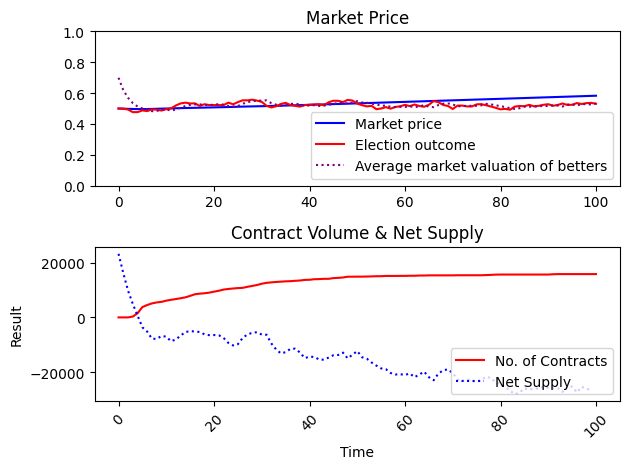

In [15]:
def plot_returns(rec): ## Election Result
    fig, ax = plt.subplots(2)
    ax[0].plot(rec['price_history'], color = "blue", label = "Market price")
    ax[0].plot(rec['gen_el'], color = "red", label = "Election outcome")
    ax[0].plot(rec['beliefs'], color = "purple", linestyle = "dotted", label = "Average market valuation of betters")

    ax[0].set_ylim(0,1)
    ax[0].legend(loc = "lower right")
    ax[1].plot(rec['vol_history'], color = "red", label = "No. of Contracts")
    ax[1].plot(rec['net_supply'], color = "blue", linestyle = "dotted", label = "Net Supply")
    ax[1].legend(loc = "lower right")

    ax[0].set_title('Market Price')
    ax[1].set_title('Contract Volume & Net Supply')

    plt.xlabel('Time')
    plt.ylabel('Result')
    plt.xticks(rotation=45)
    fig.tight_layout()

    # Display the plot
    plt.show()

plot_returns(market_record)

## Example: Decrease expertise

Below is an example in which we vary the expertise of betters. I decrease the average expertise (clarity with which the better knows the true election probability). As it is defined now, a higher value for the expertise variable means less expertise...sorry for the unintuitive labelling. But you can see that the convergence of beliefs is more volatile.

In [ ]:
# Update expertise here -> make better less expert on average - 
# higher expertise value = greater noise (not an intuitive variable label...sorry)
parameters.update({'betters': [better(expertise = np.random.normal(0.9, 0.01)) for _ in range(parameters['n_betters'])]})

market_record_low_expertise = run_market(**parameters)

plot_returns(market_record_low_expertise)

/var/folders/34/6r0xdq916zn1qsvypkxnsqkw0000gr/T/ipykernel_4438/3603352870.py:40: RuntimeWarning: invalid value encountered in scalar power
  return (w**(1-self.risk_av))/(1-self.risk_av)


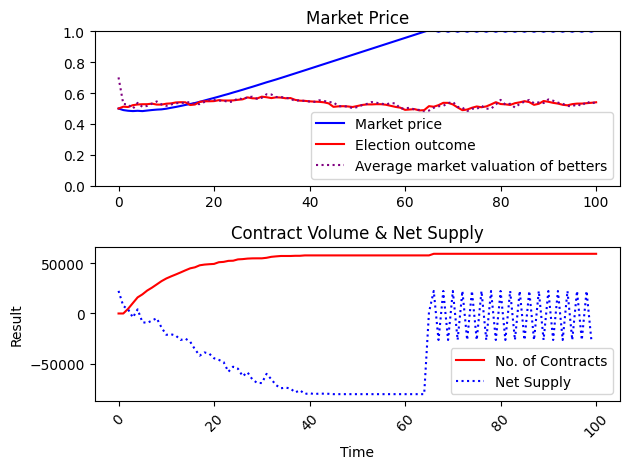

In [9]:
# Return to old instantiation of betters from first example
parameters.update({'betters': [better(expertise = np.random.normal(0.1, 0.01)) for _ in range(parameters['n_betters'])]})

def set_market_price(m, net_supply_demand, total_orders):
    ''' 
    Resetting market price function to show the issue with market price updating
    '''
    delta = net_supply_demand/(total_orders*100)
    m -= delta
    return m

poor_mkt_price = run_market(**parameters)

plot_returns(poor_mkt_price)

